# Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import pandas as pd
from modules.models import MLPWithBatchNorm, CustomNormalization
from modules.utils import train_one_epoch, test_one_epoch, isometry_gap, get_measurements
from modules.data_utils import TensorDataLoader, dataset_to_tensors
from constants import ACTIVATIONS, GAINS
from tqdm import tqdm
import os



# Setup configuration

In [2]:
# Configuration setup
config = {
    'dataset': 'MNIST', 
    'num_layers': None, #TBD
    'hidden_dim': 100,
    'batch_size': 100,
    'init_type': None, # TBD
    'norm_type': 'torch_bn',
    'activation': None, # TBD
    'learning_rate': 0.001,
    'order': 'norm_act',  
    'bias': True,
    'mean_reduction': None, # Not needed if we use default pytorch BN
    'force_factor': None, # Not needed if we use default pytorch BN
    'gain_exponent': -0.4,
    'num_epochs': 1000
}


# Load dataset


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ds = getattr(torchvision.datasets, config['dataset'])
transform = torchvision.transforms.ToTensor()  # Replace with actual transform
trainset = ds(root='../Data', train=True, download=True, transform=transform)
testset = ds(root='../Data', train=False, download=True, transform=transform)

trainloader = TensorDataLoader(*dataset_to_tensors(trainset, device=device), batch_size=config['batch_size'], shuffle=True)
testloader = TensorDataLoader(*dataset_to_tensors(testset, device=device), batch_size=config['batch_size'], shuffle=False)




# To run all night

In [ ]:
# Define the combinations of parameters
combinations = [
    
    #('orthogonal', 100, 'identity'),
    # ('orthogonal', 100, 'tanh'),
    # ('orthogonal', 100, 'sin'),
    
    # ('orthogonal', 1000, 'tanh'),
    # ('orthogonal', 1000, 'identity'),
    # ('orthogonal', 1000, 'sin'),

    ('orthogonal', 500, 'identity'),    
    ('orthogonal', 500, 'tanh'),
    ('orthogonal', 500, 'sin'),

]

save_path = 'training/mnist_v2/'
checkpoint_path = 'training/checkpoints/'

# Ensure checkpoint directory exists
os.makedirs(checkpoint_path, exist_ok=True)
os.makedirs(save_path, exist_ok=True)


for init_type, num_layers, activation in combinations:
    # Update the config dictionary with the current combination
    config['init_type'] = init_type
    config['num_layers'] = num_layers
    config['activation'] = activation

    # Instantiate the model with the updated configuration
    model = MLPWithBatchNorm(
        input_dim=1*28*28,  # Adjust for your dataset
        output_dim=10,      # Number of classes in your dataset
        num_layers=config['num_layers'],
        hidden_dim=config['hidden_dim'],
        norm_type=config['norm_type'],
        mean_reduction=config['mean_reduction'],
        activation=ACTIVATIONS[config['activation']],
        save_hidden=False,
        exponent=config['gain_exponent'],
        order=config['order'],
        force_factor=config['force_factor'],
        bias=config['bias']
    ).to(device)
    
    model.reset_parameters(config['init_type'])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])

    start_epoch = 1
    df = []
    checkpoint_file = os.path.join(checkpoint_path, f'checkpoint_d{num_layers}_{activation}_{init_type}.pt')

    # Load checkpoint if it exists
    if os.path.isfile(checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        df = checkpoint['df']

    progress_bar = tqdm(range(start_epoch, config['num_epochs'] + 1), desc="Training")
    for epoch in progress_bar:
        train_loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion, device)
        test_loss, test_acc = test_one_epoch(model, testloader, criterion, device)
        
        df.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc,
        })
        progress_bar.set_description(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'df': df,
        }, checkpoint_file)

    # Save the final results to CSV
    results_df = pd.DataFrame(df)
    save_name = f'mnist_d{num_layers}_{activation}_{init_type}.csv'
    results_df.to_csv(os.path.join(save_path, save_name))


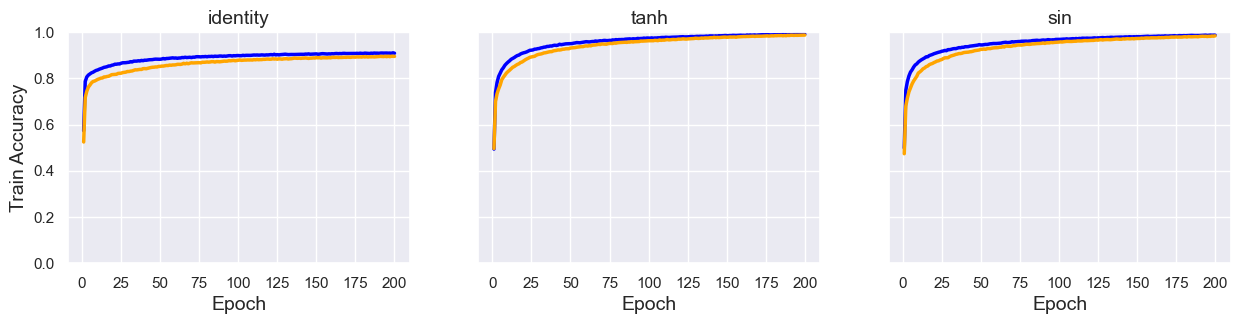

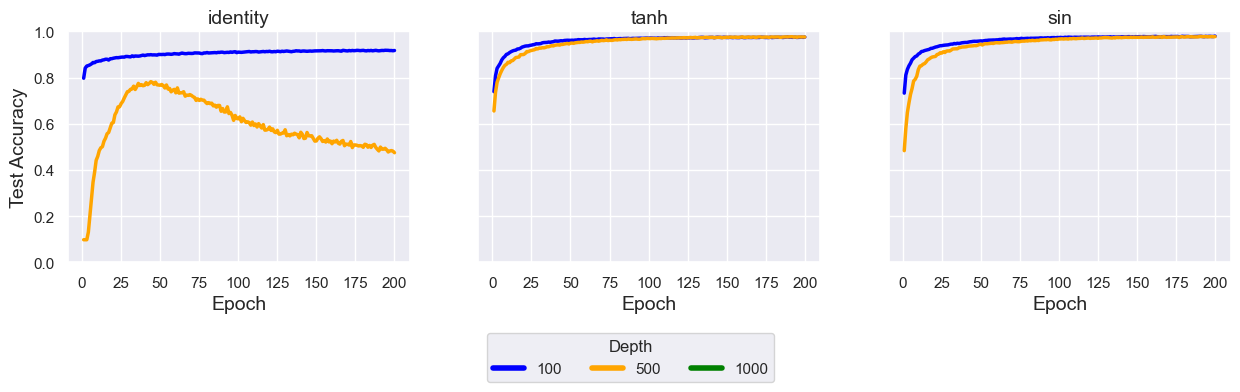

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="darkgrid")

# Increase the overall font size
plt.rcParams.update({'font.size': 14})

save_path = 'training/mnist_v2/'


# Define file names
files = {
    "identity": [
        "mnist_d100_identity_orthogonal.csv",
        "mnist_d500_identity_orthogonal.csv",
    ],
    "tanh": [
        "mnist_d100_tanh_orthogonal.csv",
        "mnist_d500_tanh_orthogonal.csv",
    ],
    "sin": [
        "mnist_d100_sin_orthogonal.csv",
        "mnist_d500_sin_orthogonal.csv",
    ]
}

# Initialize the figure for train accuracy
fig_train, axes_train = plt.subplots(1, 3, figsize=(15, 3), sharey=True)

# Initialize the figure for test accuracy
fig_test, axes_test = plt.subplots(1, 3, figsize=(15, 3), sharey=True)

# Custom colors for depth
colors = ['blue', 'orange', 'green']
depth_labels = ['100', '500', '1000']

# Loop through each activation function and its corresponding files
for idx, (activation, file_list) in enumerate(files.items()):
    for file_idx, file in enumerate(file_list):
        # Load data
        df = pd.read_csv(f"training/mnist_v2/{file}")
        
        # Filter out epochs greater than 200 and remove duplicate epochs
        df = df[df['epoch'] <= 200].drop_duplicates(subset='epoch')

        # Plot train accuracy
        sns.lineplot(ax=axes_train[idx], x=df['epoch'], y=df['train_acc'], color=colors[file_idx], linewidth=2.5)
        axes_train[idx].set_xticks(range(0,201,25))

        axes_train[idx].set_title(f"{activation}", fontsize=14)
        axes_train[idx].set_xlabel("Epoch", fontsize=14)
        axes_train[idx].set_ylabel("Train Accuracy", fontsize=14)

        # Plot test accuracy
        sns.lineplot(ax=axes_test[idx], x=df['epoch'], y=df['test_acc'], color=colors[file_idx], linewidth=2.5)
        axes_test[idx].set_xticks(range(0,201,25))
        axes_test[idx].set_title(f"{activation}", fontsize=14)
        axes_test[idx].set_xlabel("Epoch", fontsize=14)
        axes_test[idx].set_ylabel("Test Accuracy", fontsize=14)



# Set the y-axis limit
for ax in axes_train:
    ax.set_ylim(0, 1)

for ax in axes_test:
    ax.set_ylim(0, 1)

# Create a common legend for depth
custom_lines = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]


# Adjusting legends and applying tight layout for train figure
# fig_train.legend(custom_lines, depth_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, title='Depth')
fig_train.savefig("figures/train_accuracy_figure.pdf",bbox_inches='tight')

# Adjusting legends and applying tight layout for test figure
fig_test.legend(custom_lines, depth_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, title='Depth')
fig_test.savefig("figures/test_accuracy_figure.pdf",bbox_inches='tight')

